In [23]:
! pip install numpy pandas ipywidgets tqdm PyQt6 scipy gymnasium "gymnasium[other]" "gymnasium[classic-control]"

#### Imports

In [ ]:
from typing import Optional
import numpy as np
import gymnasium as gym
from collections import defaultdict
from tqdm import tqdm
from matplotlib import pyplot as plt
import pickle
from IPython.display import display, clear_output
import copy
from scipy.ndimage import zoom
from tqdm.notebook import tqdm

N_EPISODES = 10000

#### World class

In [25]:
class GridWorldEnv(gym.Env):

    def __init__(self, size: int = 10):
        # The size of the square grid
        self.size = size
        self.trajectory = []
        self.world = np.zeros((size, size)).T
        self.visited_states = np.zeros((size, size))


        # Define the agent and target location; randomly chosen in `reset` and updated in `step`
        self._agent_location = np.array([-1, -1], dtype=np.int32)
        self._target_location = np.array([-1, -1], dtype=np.int32)
        self._visited_states_near = np.zeros((3, 3))
        self._actions_taken = {}
        self._direction = np.array([-1, -1], dtype=np.int32)
        self._reward_near = np.zeros((3, 3))


        # Observations are dictionaries with the agent's and the target's location.
        # Each location is encoded as an element of {0, ..., `size`-1}^2
        self.observation_space = gym.spaces.Dict(
            {
            "agent": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "target": gym.spaces.Box(0, size - 1, shape=(2,), dtype=int),
            "visited_states_near": gym.spaces.Box(-1, 1, shape=(3, 3), dtype=int),
            "reward_near": gym.spaces.Box(-1, 1, shape=(3, 3), dtype=int),
            "actions_taken": gym.spaces.Box(0, 7, shape=(8,), dtype=int),
            "direction": gym.spaces.Box(low=-1, high=1, shape=(2,), dtype=int)  # Direction box
            }
        )

        # We have 8 actions, corresponding to "right", "up", "left", "down" and diagonal
        self.action_space = gym.spaces.Discrete(8)
        # Dictionary maps the abstract actions to the directions on the grid
        self._action_to_direction = {
            0: np.array([1, 0]),  # right
            1: np.array([0, 1]),  # up
            2: np.array([-1, 0]),  # left
            3: np.array([0, -1]),  # down
            4: np.array([1, 1]),  # up-right
            5: np.array([-1, 1]),  # up-left
            6: np.array([-1, -1]),  # down-left
            7: np.array([1, -1]),  # down-right
        }
   
    def random_env(self):
        self.world = np.random.randint(1, 11, size=(self.size, self.size))

    def heatmap_env(self):
        with open("../Kaspers_chad_pdfer_mm/heatmap/data/heatmap.pkl", "rb") as f:
            heatmap = np.rot90(pickle.load(f), k=1)
        
        heatmap_scaled = zoom(heatmap, (self.size / heatmap.shape[0], self.size / heatmap.shape[1]), order=1)  # Bilinear interpolation

        self.world = heatmap_scaled
    
    def reset_visited_states(self):
        self.visited_states = np.zeros((self.size, self.size))
    
    def world_from_matrix(self, matrix):
        self.world = matrix

    def setReward(self, x, y , reward):
        self.world[x][y] = reward

    def _get_info(self):
        return {
            "distance": np.linalg.norm(
                self._agent_location - self._target_location, ord=1
            )
        }

    def _get_obs(self):
        state_key = tuple(self._agent_location)
        actions_taken = self._actions_taken.get(state_key, np.zeros(8, dtype=int))

        return {
            "agent": self._agent_location,
            "target": self._target_location,
            "visited_states_near": self._visited_states_near,
            "actions_taken": actions_taken,
            "direction": self._direction,
            "reward_near": self._reward_near
        }



    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None):
        # We need the following line to seed self.np_random
        super().reset(seed=seed)

        # Choose the agent's location uniformly at random
        self._agent_location = self.np_random.integers(0, self.size, size=2, dtype=int)

        # We will sample the target's location randomly until it does not coincide with the agent's location
        self._target_location = self._agent_location
        while np.array_equal(self._target_location, self._agent_location):
            self._target_location = self.np_random.integers(
                0, self.size, size=2, dtype=int
            )

        observation = self._get_obs()
        info = self._get_info()

        return observation, info

    def getReward(self):
        return self.world[self._agent_location[0], self._agent_location[1]]


    def get_direction(self, action):
        return self._action_to_direction[action]
    
    def check_rewards_near(self):
        x, y = self._agent_location
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    self._reward_near[dx + 1, dy + 1] = self.world[nx][ny]

    def check_visited_near(self):
        # Create a 3x3 local view centered on the agent
        x, y = self._agent_location
        self._visited_states = np.zeros((3, 3))

        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.size and 0 <= ny < self.size:
                    self._visited_states_near[dx + 1, dy + 1] += self.visited_states[nx][ny]


    def step(self, action):
        # Map the action (element of {0,1,2,3,4,5,6,7}) to the direction we walk in
        direction = self._action_to_direction[action]
        self._direction = direction


        # We use `np.clip` to make sure we don't leave the grid bounds
        self._agent_location = np.clip(
            self._agent_location + direction, 0, self.size - 1
        )

        state_key = tuple(self._agent_location)  # Convert state to a hashable key

        # If the state is new, initialize its action history
        if state_key not in self._actions_taken:
            self._actions_taken[state_key] = np.zeros(8, dtype=int)  

        # Mark the action as taken for this specific state
        self._actions_taken[state_key][action] = 1  

         # --- Update `visited_states` ---
        grid_x, grid_y = self._agent_location
        self.visited_states[grid_x][grid_y] = 1  # Mark this grid cell as visited

        self.check_rewards_near()
        self.check_visited_near()


        # An environment is completed if and only if the agent has searched all states
        terminated = False
        truncated = False
        reward = self.getReward()
        observation = self._get_obs()
        info = self._get_info()

        

        return observation, reward, terminated, truncated, info

#### Agent Class
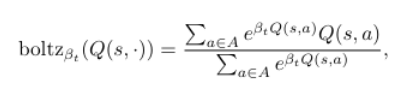

In [26]:
class SAR_agent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            env: The training environment
            learning_rate: The learning rate
            discount_factor: The discount factor for computing the Q-value
        """
        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.beta = 0.85
        self.trajectory = []

        self.training_error = []

    def reset_trajectory(self):
        self.trajectory = []

    def get_action(self, obs: dict) -> int:
        agent_state = tuple(obs['agent'])

        if agent_state not in self.q_values:
            self.q_values[agent_state] = np.zeros(self.env.action_space.n)

        q_values = self.q_values[agent_state]
        exp_q = np.exp(self.beta * q_values - np.max(self.beta * q_values))  

        # Normalize Q-values using Boltzmann
        boltzmann_probs = exp_q / np.sum(exp_q)

        # Extract reward_near (3x3 matrix)
        reward_near = obs['reward_near']

        # Create a directional bias from reward_near
        action_bias = np.zeros(self.env.action_space.n)


        # Calculate bias for each action based on nearby rewards
        for action, (dx, dy) in self.env._action_to_direction.items():
            bias_x, bias_y = dx + 1, dy + 1  # Shift index to match reward_near 3x3
            action_bias[action] = max(0, reward_near[bias_x, bias_y])  # Ensure non-negative bias

        # Normalize bias (avoid division by zero)
        if np.max(action_bias) > 0:
            action_bias = action_bias / (np.max(action_bias) + 1e-5)

        # Adjust probabilities: mix Boltzmann probabilities with bias
        adjusted_probs = boltzmann_probs + 0.1 * action_bias  

        # **Ensure probabilities are non-negative and sum to 1**
        adjusted_probs = np.maximum(adjusted_probs, 0)  # Clip negatives
        adjusted_probs /= np.sum(adjusted_probs)  # Re-normalize to sum to 1

        return np.random.choice(len(q_values), p=adjusted_probs)





    def update(
        self,
        obs: dict,  
        action: int,
        reward: float,
        terminated: bool,
        next_obs: dict,  
    ):
        # Extract agent's position and convert to tuple (ensuring it's hashable)
        agent_state = tuple(obs['agent'])  
        next_agent_state = tuple(next_obs['agent'])  

        
        
        # Access the states the agent has visited in its local neighborhood (new variable)
        self.env.visited_states
        visited_states_near = obs['visited_states_near']
        actions_taken = obs['actions_taken']
        reward_near = obs['reward_near']

            # Extract movement direction (dx, dy)

        dx, dy = obs['direction']
        nx, ny = dx + 1, dy + 1  # Convert (-1, 0, 1) to (0,1,2) for indexing

        # Initialize a dynamic penalty
        visit_penalty = 0

        # **1. Apply penalty if the direction's target state is revisited**
        if visited_states_near[nx, ny] == 1:
            visit_penalty += 5  # Moderate penalty for re-visiting a nearby cell

        # **2. Add penalty if the action was already taken before**
        if actions_taken[action] == 1:
            visit_penalty += 5  # Discourage repeating the same action

        # **3. Increase penalty based on total visit density around the agent**
        visit_penalty += np.sum(visited_states_near) * 0.1  # Higher penalty for highly visited areas






        # Ensure both current and next states exist in Q-table
        if agent_state not in self.q_values:
            self.q_values[agent_state] = np.zeros(self.env.action_space.n)
        if next_agent_state not in self.q_values:
            self.q_values[next_agent_state] = np.zeros(self.env.action_space.n)

        # Compute future Q-value using the Boltzmann policy if the episode is not terminated
        if not terminated:
            exp_q_next = np.exp(self.beta * self.q_values[next_agent_state] - np.max(self.beta * self.q_values[next_agent_state]))
            boltz_q = np.sum(exp_q_next * self.q_values[next_agent_state]) / np.sum(exp_q_next)  # Boltzmann-weighted sum of Q-values
            future_q_value = boltz_q
        else:
            future_q_value = 0  # If terminal state, no future Q-value
     

        # Compute the Temporal Difference (TD) error
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[agent_state][action] + visit_penalty
        )

        # print("temporal: ", temporal_difference)

        # Update the Q-value using the learning rate and the TD error
        self.q_values[agent_state][action] += self.lr * temporal_difference

        # Track the training error for logging or debugging
        self.training_error.append(temporal_difference)




    def plot_trajectory(self, time_step):
        """Animate the agent's trajectory on a grid."""
        plt.figure()  # Create a figure
        for i, state in enumerate(self.trajectory):
            clear_output(wait=True)  # Clears the previous plot
            plt.xlabel("X")
            plt.ylabel("Y")
            plt.title("Agent's Trajectory Simulation")
            plt.grid(True)
            
            # Plot all previous points in blue
            past_x, past_y = zip(*self.trajectory[: i + 1])  # Get all visited points
            plt.plot(past_x, past_y, "bo-", label="Past Path")  # Blue path
            
            # Plot current point in red
            plt.plot(state[0], state[1], "ro", markersize=10, label="Current Position")
            
            plt.legend()
            plt.xlim(-1, self.env.size + 1)  # Set limits to prevent resizing
            plt.ylim(-1, self.env.size + 1)
            plt.pause(time_step)  # Pause for animation
        
        plt.show()  # Keep the final plot displayed
        



#### Swarm Class

In [27]:
class swarm:
    def __init__(self, env, agents, num_agents, env_size, n_episodes):
        self.env = env
        self.agents = agents
        self.num_agents = num_agents
        self.visited_states = [[0 for _ in range(env_size)] for _ in range(env_size)]
        self.cum_reward = []    # :TODO overvej nyt navn
        self.env_size = env_size
        self.episode_cum_reward = [0 for _ in range(N_EPISODES)]
        self.n_episodes = n_episodes
        self.coverage_pr_episode = []
        self.revisits = []
        self.info_pr_episode = []

    #writes to visited states
    def state_visited(self, obs):
        x, y = obs['agent']
        self.visited_states[y][x] += 1  # mark as visited

    #reads from visited states
    def state_has_been_visited(self, obs):
        x, y = obs['agent']
        return self.visited_states[y][x] == 1

    
    def reset_trajectory(self):
        for agent in self.agents:
            agent.reset_trajectory()
    
    def add_trajectory(self, agent, obs):
        agent.trajectory.append(obs['agent'])

    def coverage_performance(self, train_env):
        covered = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                if train_env.visited_states[i][j] != 0:
                    covered += 1
        cover_percent = (covered / (train_env.size * train_env.size)) * 100
        self.coverage_pr_episode.append(cover_percent)

    def calc_revisits(self, train_env):
        revisited = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                if train_env.visited_states[i][j] == 1:
                    revisited += train_env.visited_states[i][j]
        self.revisits.append(revisited)

    def calc_info(self, train_env):
        visited_rewards = 0
        for i in range(train_env.size):
            for j in range(train_env.size):
                visited_rewards += self.env.world[i][j] * train_env.visited_states[i][j]

    
        total_rewards = np.sum(self.env.world)
        
        self.info_pr_episode.append(visited_rewards / total_rewards)


    def train_swarm(self, max_steps):
        # Use tqdm.notebook for a cleaner progress bar in Jupyter
        progress_bar = tqdm(range(self.n_episodes), desc="Training Progress", unit="episode", leave=False)

        for episode in progress_bar:
            train_env = copy.deepcopy(self.env)
            progress_bar.set_description(f"Training Progress (Episode {episode + 1}/{self.n_episodes})")

            # Reset the environment for the start of the episode
            obs, info = train_env.reset()
            self.reset_trajectory()
            train_env.reset_visited_states()
            self.cum_reward = 0
            terminated = False
            steps = 0
            done = False

            # Run the episode until termination
            while not done:
                for agent in self.agents:
                    x, y = obs['agent']
                    action = agent.get_action(obs)

                    # Take a step in the environment
                    next_obs, reward, terminated, truncated, info = train_env.step(action)

                    # Set reward in new location to 0
                    agent.update(obs, action, reward, terminated, next_obs)
                    self.add_trajectory(agent, obs)
                    self.episode_cum_reward[episode] += reward
                    train_env.setReward(x, y, -5)

                    if steps >= max_steps:
                        terminated = True

                    done = terminated or truncated
                    obs = next_obs
                    steps += 1

            self.episode_cum_reward.append(self.cum_reward)
            self.coverage_performance(train_env)
            self.calc_revisits(train_env)
            self.calc_info(train_env)

        # Ensure the last progress bar is cleared at the end
        progress_bar.close()


    def plot_reward_episode(self):
        """"Plots reward per episode"""
        plt.figure()
        x = range(self.n_episodes)
        y = self.episode_cum_reward[:self.n_episodes]

        plt.plot(x, y)
        plt.xlabel('Episodes')
        plt.ylabel('Reward')
        plt.title('Reward per Episode')
        plt.show()

    def plot_coverage_perfomance(self):
        """"Plots reward per episode"""
        plt.figure()
        x = range(self.n_episodes)
        y = self.coverage_pr_episode[:self.n_episodes]

        plt.plot(x, y)
        plt.xlabel('Episodes')
        plt.ylabel('Coverage')
        plt.title('Coverage per Episode')
        plt.show()
        
    def plot_revisited(self):
        """"Plots revisits per episode"""
        plt.figure()
        x = range(self.n_episodes)
        y = self.revisits[:self.n_episodes] 

        plt.plot(x, y)
        plt.xlabel('Episodes')
        plt.ylabel('Revisits')
        plt.title('Revisits per Episode')
        plt.show()

    def plot_info(self):
        """"Plots revisits per episode"""
        plt.figure()
        x = range(self.n_episodes)
        y = self.info_pr_episode[:self.n_episodes] 

        plt.plot(x, y)
        plt.xlabel('Episodes')
        plt.ylabel('Info')
        plt.title('Info gain per Episode')
        plt.show()
        
        



### Hyperparameters

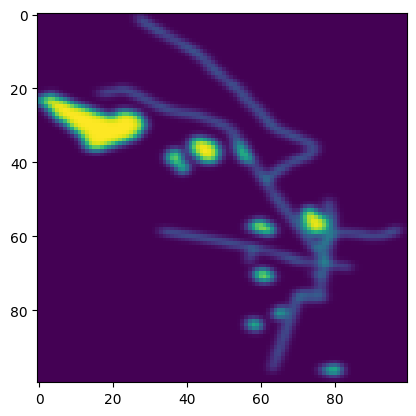

In [28]:
# hyperparameters
learning_rate = 0.1
size = 100

env = GridWorldEnv(size=size)

env.heatmap_env()

plt.imshow(env.world, cmap='viridis')

env_timelimit = gym.wrappers.TimeLimit(env, max_episode_steps=1000)

agent = SAR_agent(
    env=env,
    learning_rate=learning_rate,
)

agents = []
agents.append(agent)

In [29]:
swarm = swarm(env, agents, 15, 10, N_EPISODES)

swarm.train_swarm(300)

Training Progress:   0%|          | 0/10000 [00:00<?, ?episode/s]

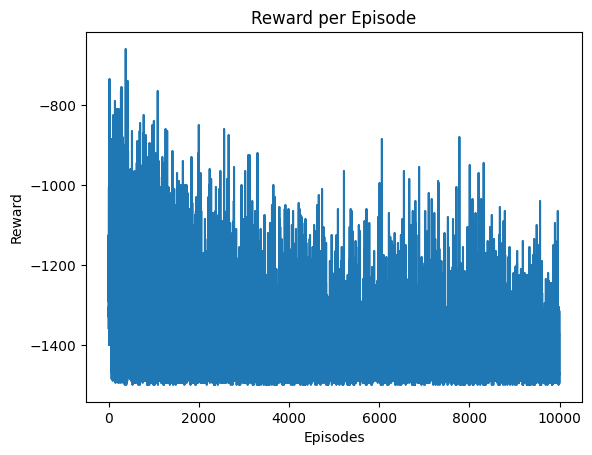

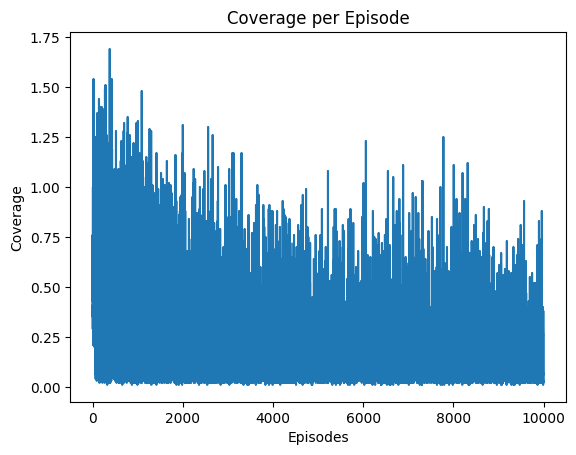

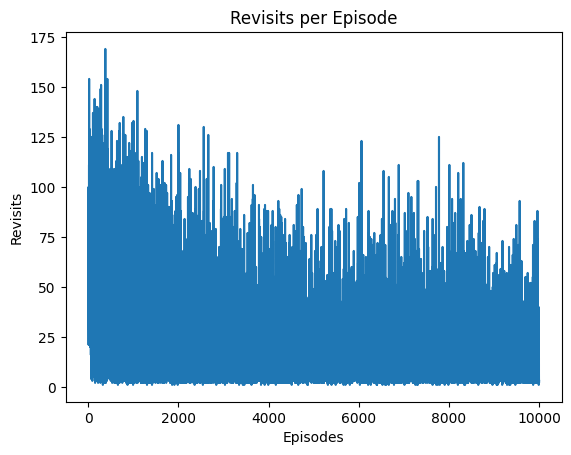

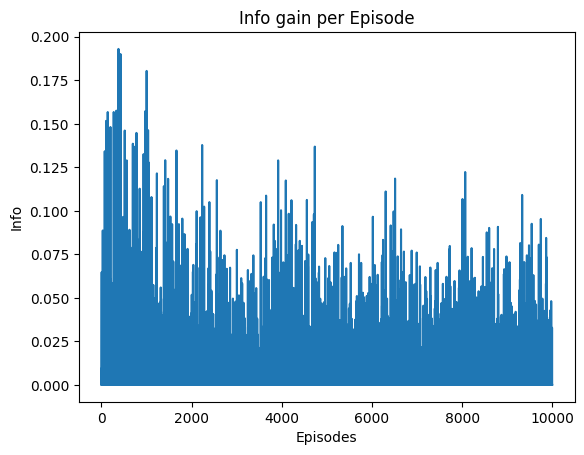

defaultdict(<function SAR_agent.__init__.<locals>.<lambda> at 0x7e17eb7d4b80>, {(np.int64(52), np.int64(78)): array([ 26.47361905, 148.07878838,   4.02001521,   9.15486182,
         5.57984752,  14.0893572 ,   0.        ,  71.89995023]), (np.int64(51), np.int64(79)): array([ 41.2568446 ,   5.78814267,   0.        ,   0.        ,
        18.1485223 ,  55.48587816, 430.50016105,  12.95406412]), (np.int64(52), np.int64(80)): array([1.08072627e+01, 5.00011003e-02, 0.00000000e+00, 2.88995907e+01,
       0.00000000e+00, 1.05389041e+01, 4.98235641e-01, 1.74263774e+02]), (np.int64(52), np.int64(81)): array([0.        , 0.        , 0.67034988, 0.        , 0.        ,
       0.07000014, 0.        , 0.83000478]), (np.int64(51), np.int64(82)): array([0.        , 0.09000001, 0.        , 0.        , 5.30927005,
       0.        , 0.        , 0.        ]), (np.int64(51), np.int64(83)): array([0.12000002, 2.70817095, 0.        , 0.        , 0.        ,
       0.        , 1.15000008, 0.        ]), (np.

In [30]:
swarm.plot_reward_episode()
swarm.plot_coverage_perfomance()
swarm.plot_revisited()
swarm.plot_info()
print(agents[0].q_values)

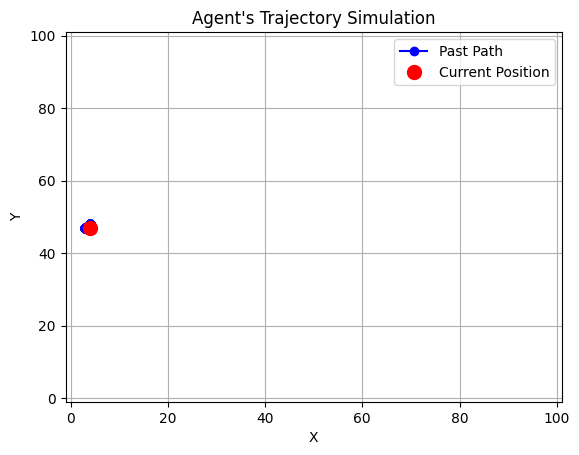

In [31]:
agents[0].plot_trajectory(0.05)

